In [0]:
import numpy as np
from PIL import Image
import os
import string
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.nn.utils.rnn import pack_padded_sequence
from torch.utils.data import DataLoader, SubsetRandomSampler, Dataset
from torchvision import models, datasets, transforms

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!mkdir project
!cp -r 'drive/My Drive/Colab Notebooks/small projects/image-captioning/captioning.py' project
!cp -r 'drive/My Drive/Colab Notebooks/small projects/image-captioning/dataset.py' project
!cp -r 'drive/My Drive/Colab Notebooks/small projects/image-captioning/model.py' project
!cp -r 'drive/My Drive/Colab Notebooks/small projects/image-captioning/utils.py' project
!cp -r 'drive/My Drive/Colab Notebooks/small projects/image-captioning/datasets' project
!cp -r 'drive/My Drive/Colab Notebooks/small projects/image-captioning/embedding' project

In [4]:
cd project

/content/project


In [0]:
from utils import get_captions, get_embedding_dict, get_embedding_matrix, get_images_list, get_padded_captions, encode_captions
from dataset import CaptioningDataset
from model import Decoder, Encoder
from captioning import Captioning

In [0]:
from zipfile import ZipFile
with ZipFile('datasets/Flickr8k_Dataset.zip') as zipObj:
    zipObj.extractall('datasets')
with ZipFile('datasets/Flickr8k_text.zip') as zipObj:
    zipObj.extractall('datasets')

In [7]:
embedding_dict = get_embedding_dict('embedding/glove.6B.200d.txt')
print(embedding_dict['the'])

['-0.071549', '0.093459', '0.023738', '-0.090339', '0.056123', '0.32547', '-0.39796', '-0.092139', '0.061181', '-0.1895', '0.13061', '0.14349', '0.011479', '0.38158', '0.5403', '-0.14088', '0.24315', '0.23036', '-0.55339', '0.048154', '0.45662', '3.2338', '0.020199', '0.049019', '-0.014132', '0.076017', '-0.11527', '0.2006', '-0.077657', '0.24328', '0.16368', '-0.34118', '-0.06607', '0.10152', '0.038232', '-0.17668', '-0.88153', '-0.33895', '-0.035481', '-0.55095', '-0.016899', '-0.43982', '0.039004', '0.40447', '-0.2588', '0.64594', '0.26641', '0.28009', '-0.024625', '0.63302', '-0.317', '0.10271', '0.30886', '0.097792', '-0.38227', '0.086552', '0.047075', '0.23511', '-0.32127', '-0.28538', '0.1667', '-0.0049707', '-0.62714', '-0.24904', '0.29713', '0.14379', '-0.12325', '-0.058178', '-0.001029', '-0.082126', '0.36935', '-0.00058442', '0.34286', '0.28426', '-0.068599', '0.65747', '-0.029087', '0.16184', '0.073672', '-0.30343', '0.095733', '-0.5286', '-0.22898', '0.064079', '0.015218',

In [8]:
train_images = get_images_list('datasets/Flickr_8k.trainImages.txt')
train_images[:3]

['2513260012_03d33305cf.jpg',
 '2903617548_d3e38d7f88.jpg',
 '3338291921_fe7ae0c8f8.jpg']

In [9]:
train_captions = get_captions('datasets/Flickr8k.token.txt', train_images)
train_captions['2513260012_03d33305cf.jpg']

['<START> a black dog is running after a white dog in the snow . <END>',
 '<START> black dog chasing brown dog through snow <END>',
 '<START> two dogs chase each other across the snowy ground . <END>',
 '<START> two dogs play together in the snow . <END>',
 '<START> two dogs running through a low lying body of water . <END>']

In [10]:
train_captions_padded, max_length = get_padded_captions(train_captions)
train_captions_padded['2513260012_03d33305cf.jpg']

['<START> a black dog is running after a white dog in the snow . <END> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>',
 '<START> black dog chasing brown dog through snow <END> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>',
 '<START> two dogs chase each other across the snowy ground . <END> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>',
 '<START> two dogs play together in the snow . <END> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>',
 '<START> two dogs running through a low lying body of wate

In [11]:
word_to_idx, idx_to_word, vocab_size = encode_captions(train_captions_padded)
print('First 5 elements of idx_to_word: ', idx_to_word[:5])
print('word_to_idx of <PAD>: ',word_to_idx['<PAD>'])

First 5 elements of idx_to_word:  ['<START>', '<END>', '<PAD>', 'a', 'child']
word_to_idx of <PAD>:  2


In [0]:
vocab_size

7708

In [0]:
embedding_matrix = get_embedding_matrix(idx_to_word, embedding_dict)

In [0]:
embedding_matrix.shape

(7708, 200)

In [0]:
dataset = CaptioningDataset('datasets/Flicker8k_Dataset', train_captions_padded, word_to_idx)

In [0]:
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [0]:
encoder = Encoder()
decoder = Decoder(embedding_matrix)

In [0]:
criterion = nn.CrossEntropyLoss()
params = list(decoder.lstm.parameters()) + list(decoder.linear.parameters())
optimizer = Adam(params, lr=0.0005)

In [0]:
captioning = Captioning(encoder, decoder, criterion, optimizer, 2, 100)

In [27]:
captioning.train(dataloader)

Epoch 0
--------
Iter 0: loss = 8.944849
Iter 100: loss = 1.367408
Iter 200: loss = 1.268336
Iter 300: loss = 1.241623
Iter 400: loss = 1.060304
Iter 500: loss = 1.076649
Iter 600: loss = 1.185126
Iter 700: loss = 1.182212
Iter 800: loss = 1.147535
Iter 900: loss = 0.930233
Epoch 1
--------
Iter 0: loss = 0.913794
Iter 100: loss = 0.799464
Iter 200: loss = 0.859101
Iter 300: loss = 1.040235
Iter 400: loss = 1.027822
Iter 500: loss = 0.917223
Iter 600: loss = 0.998224
Iter 700: loss = 0.915475
Iter 800: loss = 0.837180
Iter 900: loss = 0.753889


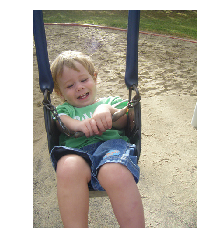

Generated caption:  a little girl in a red shirt is swinging on a swing .


In [28]:
captioning.generate_caption('datasets/Flicker8k_Dataset/2362481035_a7600875d0.jpg', word_to_idx, idx_to_word, max_length)